# Data Augmentation

Sometimes obtaining more data isn't feasible, making data augmentation a practical alternative. By modifying existing data, you can expand your dataset. This can be done either on-the-fly in the DataLoader or by pre-creating and storing augmented images directly in the dataset.

## On-the-Fly Augmentation
- **Pros**: Memory-efficient, infinite variations, avoids overfitting, easily adjustable.
- **Cons**: Slower training, potential CPU-GPU bottleneck.
- **Best for**: Large datasets and lightweight, dynamic augmentations.

## Pre-Created Augmented Dataset
- **Pros**: Faster training, consistent augmentations, reduced CPU load during training.
- **Cons**: High storage requirements, limited variation, time-consuming preprocessing.
- **Best for**: Scenarios with computationally expensive augmentations or when reproducibility is crucial.




## Augmentation Chaining with Albumentations
The Albumentations library provides an easy-to-use interface for packaging various augmentation transformations together.

In [1]:
import cv2
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

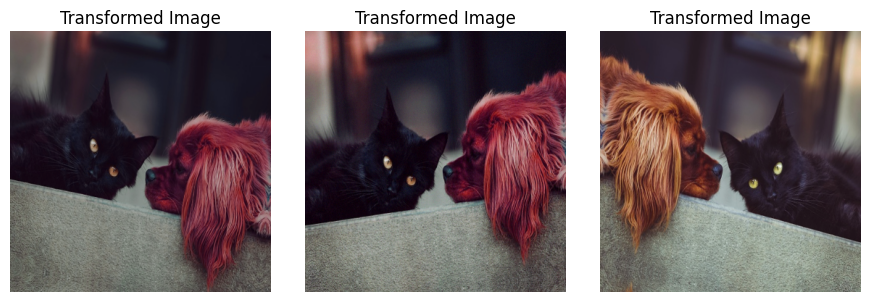

In [38]:
# Load an image using OpenCV
image_path = "data/images/image2.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Define the set of transformations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),              # Random horizontal flip
    A.RandomBrightnessContrast(p=0.7),    # Random brightness/contrast
    A.HueSaturationValue(hue_shift_limit=20, 
                         sat_shift_limit=30, 
                         val_shift_limit=20, 
                         p=0.5),          # Adjust hue, saturation, and value
    A.Rotate(limit=15, p=0.7),            # Random rotation
    A.OneOf([
        A.GaussNoise(p=0.7),              # Add Gaussian noise
        A.MotionBlur(p=0.7),              # Apply motion blur
    ], p=0.7),
    A.Resize(360, 360),                   # Resize to 128x128
    ToTensorV2()                          # Convert to PyTorch tensor
])

plt.figure(figsize=(9, 3))
cols = 3
for idx in range(cols):
    # Apply the transformations
    transformed = transform(image=image)
    transformed_image = transformed["image"]
    transformed_image_np = transformed_image.permute(1, 2, 0).numpy()
    plt.subplot(1, cols, idx + 1)
    plt.imshow(transformed_image_np)
    plt.title("Transformed Image")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

## Augmenting labels
When you scale, shift, or rotate an image, you must also apply the corresponding transformations to location-based annotations (such as bounding boxes, keypoints, polygons, etc.).

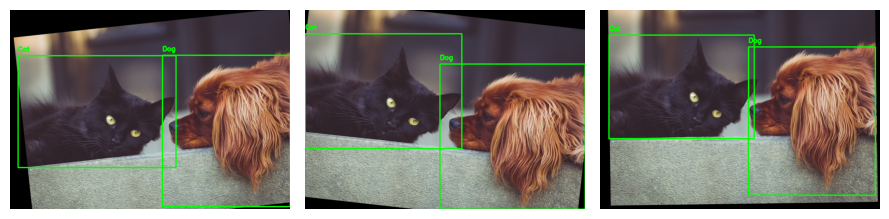

In [37]:
# Sample image and bounding boxes
image_path = "data/images/image2.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
bboxes = [
    [1.4747138, 81.424065, 346.2297, 307.62418, 0],
    [335.01868, 112.01416, 633.9916, 437.48868, 1],
]  # [x_min, y_min, x_max, y_max, class_id]
class_labels = ["Cat", "Dog"]

# Define transformations
transform = A.Compose(
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.05,
        rotate_limit=10,
        border_mode=cv2.BORDER_CONSTANT,  # Use constant border mode
        value=0,  # Pad with zeros (black)
        p=1.0
    ),
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),
)

plt.figure(figsize=(9, 3))
cols = 3
for idx in range(cols):
    plt.subplot(1, cols, idx + 1)
    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed["image"]
    transformed_bboxes = transformed["bboxes"]
    for box in transformed_bboxes:
        x_min, y_min, x_max, y_max, label = box
        cv2.rectangle(transformed_image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
        text = class_labels[int(label)]
        cv2.putText(transformed_image, text, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        plt.imshow(transformed_image)
        plt.axis('off')
plt.tight_layout()   
plt.show()

In [1]:
## Example with mnist

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Example usage
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")  # [batch_size, 1, 28, 28]
    print(f"Batch of labels shape: {labels.shape}")  # [batch_size]
    break



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3563718.74it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 292857.20it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2163333.42it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4530446.79it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Batch of images shape: torch.Size([64, 1, 28, 28])
Batch of labels shape: torch.Size([64])
